# Import modules

These are all the python modules and datacube modules that we need to work with both the guage data and the satellite data.

In [1]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser

#We have to add the plotting tools to the directory list with path.append
sys.path.append('../10_Scripts/')
import DEAPlotting, DEADataHandling

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

%load_ext autoreload

%autoreload 2

# Get WOfS data

The satellite data we will be using is the Water Observations from Space dataset, which is a Digital Earth Australia product that uses landsat data to highlight water bodies. The data is stored on the super computers at ANU, which you need approved access to. The dataset is called wofs_albers which is day by day satellite image data with water bodies highlighted. 

The code below calls the wofs_albers dataset from the Geoscience datacube. To tell it which satellite images to return, create a query, which is a dictionary for the data. Select the longtitude, latitude and the area around that point you want to return (buffer, in meters squared). The coordinate reference station (crs) for most of Australia will be EPSG 3577. Enter the timeframe over which you want to load the data in yyyy-mm-dd format. The longer the time period, the more memory you will use and it will take longer to load. 

Use the dc.load function to load your data query. This might take a while to run.

In [7]:
#I would eventually like to be able to automate the lat lon selection depending on the selected gauge
lat, lon, buffer = -35.75, 148.66, 6500

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('2000-01-01', '2019-01-01'),
         'crs': 'EPSG:3577'} 

dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', **query)

# Cloud mask

This code is a loop that runs through all the satellite data you have loaded and uses the masking tool we imported earlier to check each satellite pass for cloud, then either accepts or rejects the pass based on how much percentage cloud the user specifies as acceptable (it reads the bitflags to tell how much cloud there is). I chose 20% cloud as acceptable because you can still see the dam up until about 20% cloud coverage. After we run this code, the wofs_albers function will only return satellite data where you can actually see the dam, not data from cloudy days. 

In [8]:
ClearTimesteps = []
#Make a for-loop
for ix, timestep in enumerate(wofs_albers.time):
    SingleTime = wofs_albers.water.isel(time=ix)
    IsItCloudy = masking.make_mask(SingleTime, cloud=True)
    CountClouds = IsItCloudy.sum()
    
#Here's the part that measures the percentage of bit flags that mean cloud in the satellite image
    PercentCloudy = CountClouds.values.item()/(len(wofs_albers.x)*len(wofs_albers*y))*100
#And here's the part where we select how much cloud we're willing to accept in our satellite images. try 20. 
    IsItClearEnough = PercentCloudy <= 20
    
#Then we say 'if IsItClearEnough = True, then append it to an index called ClearTimesteps'.
    if IsItClearEnough:
        ClearTimesteps.append(ix)
#redefine wofs_albers so that it only returns useable data (ie clear passes)
wofs_albers = wofs_albers.water.isel(time = ClearTimesteps)

# Get gauge data as xarray

Now we load the gauge data we got from the Water Data Online website. The data is in a csv file, which we can read with the pandas module using the pd.read_csv function. I had to give the function a lot of arguments so it could be converted to an xarray because the data was in kind of a weird format. the .to_xarray() function converts the csv file to an xarray. 

In [9]:
#load csv file and skip data description lines.
gd = pd.read_csv('/g/data/r78/kd6095/dea-notebooks/Tantangara/Tantangara_water_level.csv',
                error_bad_lines = False, skiprows=9, escapechar='#', 
                         parse_dates=['Timestamp'], #Tells it this column is dates
                         index_col=('Timestamp'), 
                         date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))

gd_xr = gd.to_xarray()

# Merge

OK this is the fun part where we get to link the gauge data to the satellite data by date! The .interp function matches data together based on the dimensions you give it. In this case we will ask it to match the time dimensions from each dataset. The Timestamp part is what the time dimension in the gauge data is called and we set that to equal the wofs_albers time dimension, which is just wofs_albers.time.

In [10]:
merged_data = gd_xr.interp(Timestamp=wofs_albers.time)

We can plot the merged data set and it will show us the data as 'days that had clear satellite passes' plotted against the corresponding water level on that pass. 

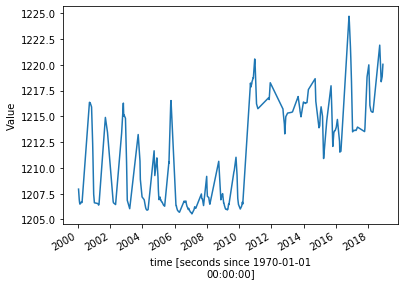

In [11]:
merged_data.Value.plot()

Great, so this is a plot of what the water level was at each clear pass! Nice. 